In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [57]:
def add_48hr_rolling(df):
    # Can't use np.roll b/c it does not deal with NANs
    # in a sophisticated manner.  Use np.nanmean which
    # skips all NANs and leaves them out of the sum and
    # division
    rolling = np.empty((0,), float)
    
    for i in range(len(df.index)):
        lst = df.loc[i-24:i+23]
        val = np.nanmean(lst['demand (MW)'])
        rolling = np.append(rolling, val)
    
    return df.assign(rolling48=rolling)

# delta with previous and following time steps
def add_deltas(df):
    diff = df['demand (MW)'].diff()
    df = df.assign(diff_pre=diff)
    diff = df['demand (MW)'].diff(periods=-1)
    df = df.assign(diff_post=diff)
    return df


# Filter on a multiplier of the IQR and set
# the associated 'demand (MW)' value to NAN.
# Filter on 1 multiplier for double deltas
# and another for single jumps
def filter_deltas(df, iqr, m_double, m_single):
    for index, row in df.iterrows():
        if abs(row['diff_pre']) > iqr * m_single:
            df.at[index, 'demand (MW)'] = np.nan
        elif abs(row['diff_post']) > iqr * m_single:
            df.at[index, 'demand (MW)'] = np.nan
        elif abs(row['diff_pre']) > iqr * m_double and \
                abs(row['diff_post']) > iqr * m_double:
            df.at[index, 'demand (MW)'] = np.nan     
    return df


def filter_extrems(df, multiplier):
    dem_iqr = np.percentile(df['demand (MW)'].dropna(), 75)
    dem_iqr -= np.percentile(df['demand (MW)'].dropna(), 25)
    df['demand (MW)'] = df['demand (MW)'].mask(df['demand (MW)'] > dem_iqr * multiplier)
    return df

def mark_missing_and_empty(df, col):
    #marked = np.zeros(len(df.index))
    print(df[col].isna())

def show_structure(df):
    plt.imshow(~df.isna(), aspect='auto')
    plt.xlabel("variables")
    plt.ylabel("cases")
    plt.gray()
    plt.show()

def make_diff_plot(df, save):
    plt.close()
    fig, ax = plt.subplots()
    n, bins, patches = ax.hist(df['diff_pre'], 100, facecolor='red', alpha=0.2, label='pre')
    n, bins, patches = ax.hist(df['diff_post'], 100, facecolor='blue', alpha=0.2, label='post')
    ax.set_xlabel('Demand Difference (MW)')
    ax.set_ylabel('Counts')
    plt.tight_layout()
    plt.yscale('log', nonposy='clip')
    plt.savefig(save)

def make_dem_hist(df, save):
    plt.close()
    fig, ax = plt.subplots()
    n, bins, patches = ax.hist(df['demand (MW)'], 100, facecolor='red', alpha=0.2, label='pre')
    #n, bins, patches = ax.hist(df['diff_post'], 100, facecolor='blue', alpha=0.2, label='post')
    ax.set_xlabel('Demand (MW)')
    ax.set_ylabel('Counts')
    plt.tight_layout()
    plt.yscale('log', nonposy='clip')
    plt.savefig(save)

iqr pre 16.00 x 5 = 80.00
diff_pre 25% -8.00  75% 8.00


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


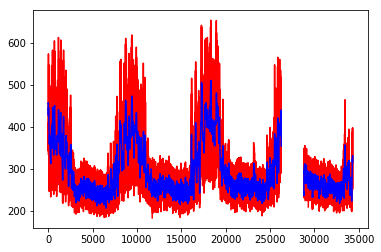

In [58]:
dem_map = {}
regions = ['TIDC',]# 'BANC', 'CISO', 'LDWP']
for region in regions:
    file_path = '../get_eia_demand_data/data/{}.csv'.format(region)
    dem_map[region] = pd.read_csv(file_path, #index_col='time',
                       dtype={'demand (MW)':np.float64},
                      parse_dates=True, na_values=['MISSING', 'EMPTY'])
    
    # Convert date/time
    dem_map[region]['time'] = pd.to_datetime(dem_map[region]['time'])

    # Make missing and empty values
    dem_map[region] = dem_map[region].assign(missing=dem_map[region]['demand (MW)'].isna())
    
    # Set all negative and zero values to NAN
    dem_map[region]['demand (MW)'] = dem_map[region]['demand (MW)'].mask(dem_map[region]['demand (MW)'] <= 0.)
    
    # Add deltas
    dem_map[region] = add_deltas(dem_map[region])
    
    # Plots
    make_diff_plot(dem_map[region], 'diffs_original_{}.png'.format(region))
    make_dem_hist(dem_map[region], 'dem_original_{}.png'.format(region))
    
    # Calculate IQR for the deltas
    iqr = np.percentile(dem_map[region]['diff_pre'].dropna(), 75) - \
                np.percentile(dem_map[region]['diff_pre'].dropna(), 25)
    
    print("iqr pre {:.2f} x 5 = {:.2f}".format(iqr, iqr*5))
    print('diff_pre 25% {:.2f}  75% {:.2f}'.format(np.percentile(dem_map[region]['diff_pre'].dropna(), 25),
                                                  np.percentile(dem_map[region]['diff_pre'].dropna(), 75)))
    
    #print(dem_map[region].describe().round(2))
    multiplier_double = 4
    multiplier_single = 6
    dem_map[region] = filter_deltas(dem_map[region], iqr, multiplier_double, multiplier_single)
    
    
    # Filter on extreme demand values
    multiplier = 10
    dem_map[region] = filter_extrems(dem_map[region], multiplier)
    
    
    # Add rolling 48 hr average
    dem_map[region] = add_48hr_rolling(dem_map[region])

    #print(dem_map[region].head())
    #print(dem_map[region].loc[1000:1005])

    plt.close()
    fig, ax = plt.subplots()
    ax.plot(dem_map[region]['demand (MW)'], 'r-', label='demand')
    ax.plot(dem_map[region]['rolling48'], 'b-', label='rolling 48hr')
    plt.savefig('demand_{}.png'.format(region))

In [ ]:
df = dem_map['CISO']
for k, v in dem_map.items():
    print(k)
    kwargs = {k : lambda x: v['demand (MW)'],
              '{}_Lag1'.format(k) : lambda x: np.roll(v['demand (MW)'], +1),
             }
    df = df.assign(**kwargs)
print(df.head())

In [ ]:
for remove in ['series_id', 'year', 'month', 'day', 
               'hour', 'demand (MW)', 'forecast demand (MW)',
               'time',
               'diff_pre', 'diff_post'
              ]:
    df = df.drop(remove, axis=1)
df.head()

In [ ]:
df.describe().round(2)

In [ ]:
df.isna().sum(axis=0)

In [ ]:
plt.imshow(~df.isna(), aspect='auto')
plt.xlabel("variables")
plt.ylabel("cases")
plt.gray()
plt.show()